In [1]:
import rasterio
from rasterio.crs import CRS
import geopandas as gpd
from shapely.geometry import box
import matplotlib.pyplot as plt
from tqdm import tqdm
from boto3.s3.transfer import TransferConfig
import boto3
from rasterio.session import AWSSession
from pathlib import Path
import tempfile
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support as score
import numpy as np
import pandas as pd
from dem_stitcher.rio_tools import rasterize_shapes_to_array, get_cropped_profile
import rasterio.plot as plot
from rasterio.io import MemoryFile

# Get AWS Session

In [2]:
session = boto3.session.Session(profile_name='saml-pub')
s3 = session.resource('s3')

# Get Metadata for Hansen Tiles in GeoDataFrame

In [3]:
obj = s3.Object('calval-metadata', 'test-prod--cropped-hansen-landsat-mosaics-2020.geojson')
obj.get()

{'ResponseMetadata': {'RequestId': '6403HGWBYBDQVJRX',
  'HostId': 'XnLFAnF+m6WdBDJFPaxAn8pld1dMOXpUjngbTJsahUUMBmwfipPOFG3EY/AlFZRId7itUyaAXck=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'XnLFAnF+m6WdBDJFPaxAn8pld1dMOXpUjngbTJsahUUMBmwfipPOFG3EY/AlFZRId7itUyaAXck=',
   'x-amz-request-id': '6403HGWBYBDQVJRX',
   'date': 'Mon, 03 Jan 2022 22:22:45 GMT',
   'last-modified': 'Mon, 03 Jan 2022 21:54:58 GMT',
   'etag': '"9ddaa0f0935cbe8479d4216a0b156929"',
   'accept-ranges': 'bytes',
   'content-type': 'binary/octet-stream',
   'server': 'AmazonS3',
   'content-length': '1135'},
  'RetryAttempts': 0},
 'AcceptRanges': 'bytes',
 'LastModified': datetime.datetime(2022, 1, 3, 21, 54, 58, tzinfo=tzutc()),
 'ContentLength': 1135,
 'ETag': '"9ddaa0f0935cbe8479d4216a0b156929"',
 'ContentType': 'binary/octet-stream',
 'Metadata': {},
 'Body': <botocore.response.StreamingBody at 0x7f35940c09a0>}

<AxesSubplot:>

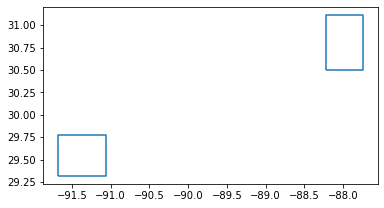

In [4]:
data = obj.get()['Body']
df_deltas = gpd.read_file(data)
df_deltas.exterior.plot()

In [5]:
records = df_deltas.to_dict('records')

# Read Data with Rasterio (Example)

Look at the previous notebook on how to download files. We are going to read files directly from s3 because they are small enough.

In [6]:
record = records[0]
record

{'bucket': 'test-prod--cropped-hansen-landsat-mosaics-2020',
 'key': 'Hansen_GFC-2020-v1.8_last_30N_100W.tif',
 'source_url': 'https://storage.googleapis.com/earthenginepartners-hansen/GFC-2020-v1.8/Hansen_GFC-2020-v1.8_last_30N_100W.tif',
 'year': 2020,
 'geometry': <shapely.geometry.polygon.Polygon at 0x7f35940c11b0>}

In [7]:
bucket = record['bucket']
key = record['key']

with rasterio.Env(AWSSession(session)):
    with rasterio.open(f's3://{bucket}/{key}') as ds:
        profile = ds.profile
        img = ds.read()
        
profile

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 2473, 'height': 1810, 'count': 4, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00025, 0.0, -91.6785,
       0.0, -0.00025, 29.77325), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'pixel'}

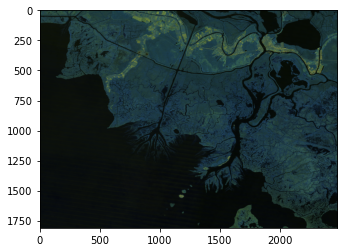

In [8]:
plt.imshow(img.transpose([1, 2, 0])[:, :, [3, 2, 1]])

# Load Training Data

Rasterio [docs](https://rasterio.readthedocs.io/en/stable/topics/features.html#burning-shapes-into-a-raster) on rasterizing.

In [9]:
training_df = gpd.read_file('training_data.geojson')
training_df['label'] = training_df['label'].astype(int)
training_df

,label_name,label,geometry
0,water,1,"POLYGON ((-91.64780 29.59595, -91.56497 29.545..."
1,land,2,"POLYGON ((-91.48979 29.64931, -91.48077 29.650..."
2,water,1,"POLYGON ((-91.27249 29.54203, -91.26561 29.544..."
3,land,2,"POLYGON ((-91.16359 29.46521, -91.15677 29.465..."
4,land,2,"POLYGON ((-91.45266 29.73740, -91.44468 29.737..."


In [10]:
class2label = {'water': 1, 'land': 2}
label2class = {v: k for k, v in class2label.items()}

In [11]:
training_arr = rasterize_shapes_to_array(training_df.geometry,
                                         training_df.label.tolist(),
                                         profile,
                                         all_touched=False,
                                         dtype='uint8')

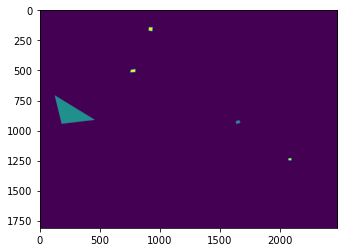

In [12]:
plt.imshow(training_arr)

# Train Model and Test

We are going to test the model by training the data on a subset of the labeled data. For the validation dataset, we will simply apply the model to the entire dataset.

In [13]:
labeled_pixels_ind = (training_arr != 0)



img_hansen = img.transpose([1, 2, 0])
X = img_hansen[labeled_pixels_ind, :]
y = training_arr[labeled_pixels_ind]

X.shape, y.shape

((36184, 4), (36184,))

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

In [15]:
rf = RandomForestClassifier(n_estimators=500,
                            oob_score=True,
                            random_state=0,
                            # Automatically parallelizes!
                            n_jobs=10
                            ) 

In [16]:
%%time

rf.fit(X_train, y_train)

CPU times: user 2.94 s, sys: 307 ms, total: 3.24 s
Wall time: 2.03 s


RandomForestClassifier(n_estimators=500, n_jobs=10, oob_score=True,
                       random_state=0)

In [17]:
%%time

y_pred = rf.predict(X_test)

CPU times: user 472 ms, sys: 32.1 ms, total: 504 ms
Wall time: 252 ms


In [18]:
y_pred_str = pd.Series([label2class[class_id] for class_id in y_pred], name='Predicted')
y_true_str = pd.Series([label2class[class_id] for class_id in y_test], name='True')

In [19]:
df = pd.crosstab(y_true_str, y_pred_str)
df

Predicted,land,water
True,,
land,1168,0
water,0,16924


In [39]:
precision, recall, fscore, support = score(y_test, y_pred)


In [40]:
index = df.index
df_scores = pd.DataFrame({'Producer': precision,
                          'User': recall,
                         },
                         index = index)
df_scores

,Producer,User
True,,
land,1.0,1.0
water,1.0,1.0


# Apply to Entire Area

In [41]:
%%time

X_all = img_hansen.reshape((-1, 4))
y_all = rf.predict(X_all)

class_arr = y_all.reshape(img_hansen.shape[0], img_hansen.shape[1])

CPU times: user 1min 27s, sys: 22.1 s, total: 1min 49s
Wall time: 22.2 s


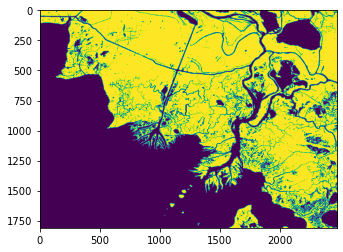

In [42]:
plt.imshow(class_arr)

# Writing Classification

In [24]:
profile_class = profile.copy()
profile_class['count'] = 1
profile_class['dtype'] = 'uint8'
profile_class['nodata'] = 0

with rasterio.open('classification_sample.tif', 'w', **profile_class) as ds:
    ds.write(class_arr, 1)

# Automate Classification

In [25]:
def read_one_mosaic(record):
    bucket = record['bucket']
    key = record['key']

    with rasterio.Env(AWSSession(session)):
        with rasterio.open(f's3://{bucket}/{key}') as ds:
            profile = ds.profile
            img = ds.read()
    return img, profile

def classify_scene(record):
    
    img, profile = read_one_mosaic(record)
    img_bsq = img.transpose([1, 2, 0])
    X_all = img_bsq.reshape((-1, 4))
    y_all = rf.predict(X_all)

    class_arr = y_all.reshape(img_bsq.shape[0], img_bsq.shape[1])
    
    class_profile = profile.copy()
    class_profile['count'] = 1
    class_profile['dtype'] = 'uint8'
    class_profile['nodata'] = 0
    
    return class_arr, class_profile

In [26]:
X, prof = classify_scene(records[1])

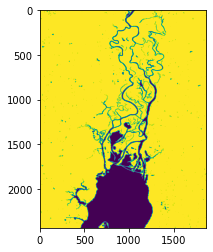

In [27]:
plt.imshow(X)

 # Upload Classification
 
 ## Metadata

In [28]:
df_class = df_deltas.copy()

df_class['bucket'] = 'test-prod--water-class-from-2020-hansen-landsat'

In [29]:
bucket_name = df_class.bucket[0]
buckets = list(s3.buckets.all())
print(bucket_name)
if bucket_name not in [b.name for b in buckets]:
    s3.Bucket(bucket_name).create(CreateBucketConfiguration={'LocationConstraint': 'us-west-2'})

test-prod--water-class-from-2020-hansen-landsat


In [30]:
geojson_bytes = bytes(df_class.to_json(drop_id=True).encode('UTF-8'))
geojson_bytes

b'{"type": "FeatureCollection", "features": [{"type": "Feature", "properties": {"bucket": "test-prod--water-class-from-2020-hansen-landsat", "key": "Hansen_GFC-2020-v1.8_last_30N_100W.tif", "source_url": "https://storage.googleapis.com/earthenginepartners-hansen/GFC-2020-v1.8/Hansen_GFC-2020-v1.8_last_30N_100W.tif", "year": 2020}, "geometry": {"type": "Polygon", "coordinates": [[[-91.678270890115, 29.320518966016902], [-91.06014651033061, 29.320518966016902], [-91.06014651033061, 29.77309292820278], [-91.678270890115, 29.77309292820278], [-91.678270890115, 29.320518966016902]]]}}, {"type": "Feature", "properties": {"bucket": "test-prod--water-class-from-2020-hansen-landsat", "key": "Hansen_GFC-2020-v1.8_last_40N_090W.tif", "source_url": "https://storage.googleapis.com/earthenginepartners-hansen/GFC-2020-v1.8/Hansen_GFC-2020-v1.8_last_40N_090W.tif", "year": 2020}, "geometry": {"type": "Polygon", "coordinates": [[[-88.21591391901751, 30.503890401521048], [-87.74982410210579, 30.503890401

In [31]:
geojson_bucket = 'calval-metadata'
geojson_key = f'{df_class.bucket[0]}.geojson'

s3object = s3.Object(geojson_bucket, geojson_key)
s3object.put(Body=geojson_bytes)

{'ResponseMetadata': {'RequestId': 'K5SH4PNDQBEKXQZK',
  'HostId': '9KoLJQtgIHn6LVLRbEOx6phsXJndh9sPPEI/5xeXCxZfGQpMDB1RIf5d9VjLLO6/Wnc3yUx+iqY=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '9KoLJQtgIHn6LVLRbEOx6phsXJndh9sPPEI/5xeXCxZfGQpMDB1RIf5d9VjLLO6/Wnc3yUx+iqY=',
   'x-amz-request-id': 'K5SH4PNDQBEKXQZK',
   'date': 'Mon, 03 Jan 2022 22:23:53 GMT',
   'etag': '"0b429c65865dbbfb282659956a6d1c86"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"0b429c65865dbbfb282659956a6d1c86"'}

# Upload Arrays

In [32]:
class_records = df_class.to_dict('records')

In [33]:
config = TransferConfig(multipart_threshold=1024, 
                            max_concurrency=30,
                            # Commenting this out appears to make upload speed more variable
                            #multipart_chunksize=1024, 
                            use_threads=True)
def classify_and_upload(old_record, new_record):
    
    X, prof = classify_scene(old_record)
    
    s3_bucket = new_record['bucket']
    s3_key = new_record['key']
    
    bucket = s3.Bucket(s3_bucket)
    with MemoryFile() as mem_file:
        with mem_file.open(**prof) as dataset:
            dataset.write(X, 1)
            
        # memfile has nbytes for total size
        # must be closed for correct viewing
        # source: https://github.com/rasterio/rasterio/blob/master/tests/test_memoryfile.py#L148-L151
        view = mem_file.getbuffer()
        total_size = view.size
        with tqdm(total=total_size,  
                  unit='B', 
                  unit_scale=True, 
                  unit_divisor=1024,
                  desc=f'upload {s3_key}') as pbar:
                
            # memfile must be closed before writing otherwise will be "incorrect file format"
            bucket.upload_fileobj(mem_file, s3_key, Config=config, Callback=pbar.update)
    
    return f'{s3_bucket}/{s3_key}'

In [34]:
from itertools import starmap

list(starmap(classify_and_upload, zip(records, tqdm(class_records))))

  0%|                                                               | 0/2 [00:00<?, ?it/s]
upload Hansen_GFC-2020-v1.8_last_30N_100W.tif:   0%|           | 0.00/148k [00:00<?, ?B/s]
upload Hansen_GFC-2020-v1.8_last_30N_100W.tif: 100%|████| 148k/148k [00:00<00:00, 249kB/s]
 50%|███████████████████████████▌                           | 1/2 [00:22<00:22, 22.98s/it]
upload Hansen_GFC-2020-v1.8_last_40N_090W.tif:   0%|          | 0.00/82.5k [00:00<?, ?B/s]
upload Hansen_GFC-2020-v1.8_last_40N_090W.tif: 100%|██| 82.5k/82.5k [00:00<00:00, 186kB/s]
 50%|███████████████████████████▌                           | 1/2 [00:41<00:41, 41.42s/it]


['test-prod--water-class-from-2020-hansen-landsat/Hansen_GFC-2020-v1.8_last_30N_100W.tif',
 'test-prod--water-class-from-2020-hansen-landsat/Hansen_GFC-2020-v1.8_last_40N_090W.tif']